In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
      
# for plots and aniamtions
import matplotlib.pyplot as plt
#plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (5,5)
import matplotlib.animation as animation
from IPython.display import HTML

# for the computation
import torch as th
th.manual_seed(1234)
import torch.optim as optim
from torch.distributions import MultivariateNormal
import numpy as np
from tqdm import tqdm

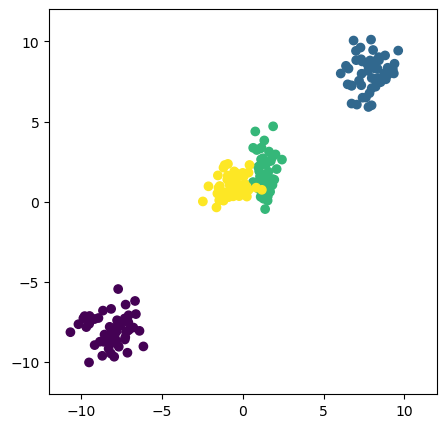

In [2]:
# create the data
num_classes = 4
D = 2

a = th.randn(D,D)
b = th.randn(D,D)

x = th.cat((MultivariateNormal(-8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(8 * th.ones(D), th.eye(D)).sample([50]),
            MultivariateNormal(th.tensor([1.5, 2]), a @ a.T).sample([50]),
            MultivariateNormal(th.tensor([-0.5, 1]), b@b.T).sample([50])))

y = th.cat((0*th.ones(50),
            1*th.ones(50),
            2*th.ones(50),
            3*th.ones(50))).to(th.int64)

#x = (x-th.mean(x, dim=0, keepdim=True)) / th.std(x, dim=0, keepdim=True)
plt.xlim(-12,12)
plt.ylim(-12,12)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

## Train a Gaussina DPMM

In [3]:
# define the model
from torch_dpmm.models import DiagonalGaussianDPMM, FullGaussianDPMM, SingleGaussianDPMM, UnitGaussianDPMM
from plot_utils import plot_Gauss2D_contour
K = 100
D = 2

############ CHANGE THE PRIOR HYPER PARAMETERS TO OBTAIN DIFFERENT RESULTS ############
alphaDP = 10
mu_prior = 0
mu_prior_strenght = 0.01
var_prior = 0.1
var_prior_strenght = 100
#######################################################################################

my_DPMM_full = FullGaussianDPMM(K, D, alphaDP, mu_prior, mu_prior_strenght, var_prior, var_prior_strenght)
my_DPMM_diag = DiagonalGaussianDPMM(K, D, alphaDP, mu_prior, mu_prior_strenght, var_prior, var_prior_strenght)
my_DPMM_sing = SingleGaussianDPMM(K, D, alphaDP, mu_prior, mu_prior_strenght, var_prior, var_prior_strenght)
my_DPMM_unit = UnitGaussianDPMM(K, D, alphaDP, mu_prior, mu_prior_strenght)


def train_DPMM(m, title=None, num_iterations=100, lr=0.8):
    m.init_var_params(x)
    
    optimiser = optim.SGD(params=m.parameters(), lr=lr)

    # for the animation
    plt.ioff()
    fig, ax = plt.subplots()
    if title is not None:
        ax.set_title(title)
        ax.set_xlim(-12, 12)
        ax.set_ylim(-12, 12)
        
    lines_to_plot = []

    pbar = tqdm(range(num_iterations))
    elbo_losses = []
    
    
    x_np = x.detach().numpy()
    to_plot = [ax.scatter(x_np[:, 0], x_np[:, 1], c=y.numpy(),animated=True)]
    pi, (mu, Sigma) = m.get_expected_params()
    pi = pi.numpy()
    mu = mu.numpy()
    Sigma = Sigma.numpy()
    for k in range(K):
        if pi[k]>0:
            to_plot += (plot_Gauss2D_contour(mu[k], Sigma[k], ax=ax, animated=True))

    lines_to_plot.append(to_plot)
    
    for j in pbar:
        optimiser.zero_grad()
        pi, elbo_loss, _ = m(x)
        elbo_loss.backward()
        optimiser.step()
        elbo_losses.append(elbo_loss.detach().item())

        pbar.set_postfix({'ELBO loss': elbo_loss.detach().item()})

        if j % 1 ==0:
            x_np = x.detach().numpy()
            to_plot = [ax.scatter(x_np[:, 0], x_np[:, 1], c=y.numpy(),animated=True)]
            pi, (mu, Sigma) = m.get_expected_params()
            pi = pi.numpy()
            mu = mu.numpy()
            Sigma = Sigma.numpy()
            for k in range(K):
                if pi[k]>0.01:
                    to_plot += (plot_Gauss2D_contour(mu[k], Sigma[k], ax=ax, animated=True))

            lines_to_plot.append(to_plot)
    anim = animation.ArtistAnimation(fig, lines_to_plot, repeat=True, interval=100, blit=True)
    plt.ion();
    plt.close();
    
    return m, elbo_losses, anim, fig




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.46it/s, ELBO loss=2.36]


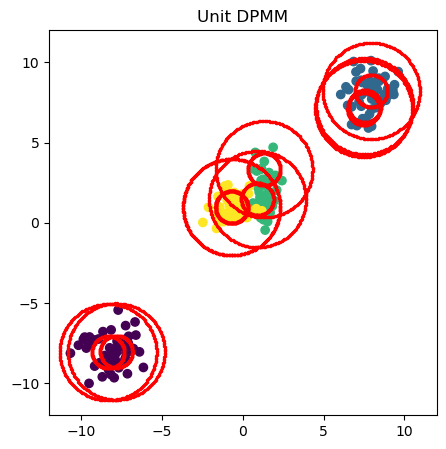

In [4]:
# my_DPMM_unit.init_var_params(x)
my_DPMM_unit, elbo_unit, anim_unit, f_unit = train_DPMM(my_DPMM_unit, 'Unit DPMM')
HTML(anim_unit.to_html5_video())
f_unit # comment this line to see the animation

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s, ELBO loss=2.7]


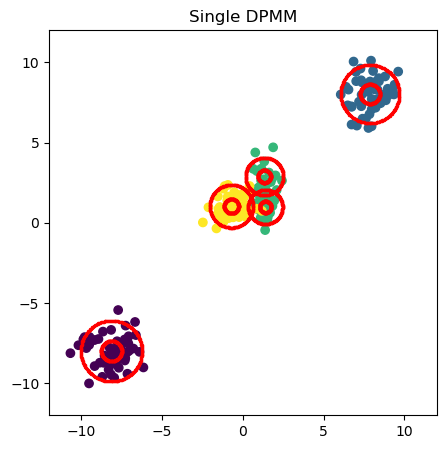

In [5]:
# my_DPMM_sing.init_var_params(x)
my_DPMM_sing, elbo_sing, anim_sing, f_sing = train_DPMM(my_DPMM_sing, 'Single DPMM')
HTML(anim_sing.to_html5_video())
f_sing # comment this line to see the animation

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.33it/s, ELBO loss=2.75]


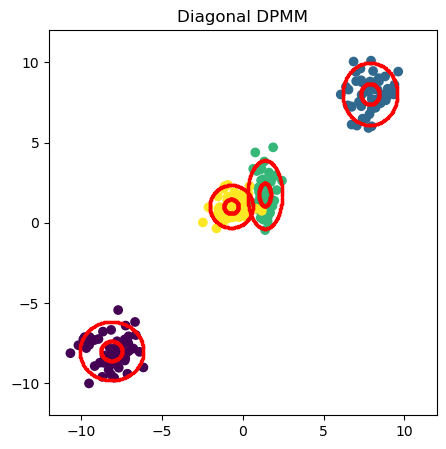

In [6]:
# my_DPMM_diag.init_var_params(x)
my_DPMM_diag, elbo_diag, anim_diag, f_diag = train_DPMM(my_DPMM_diag, 'Diagonal DPMM')
HTML(anim_diag.to_html5_video())
f_diag # comment this line to see the animation

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.27it/s, ELBO loss=2.79]


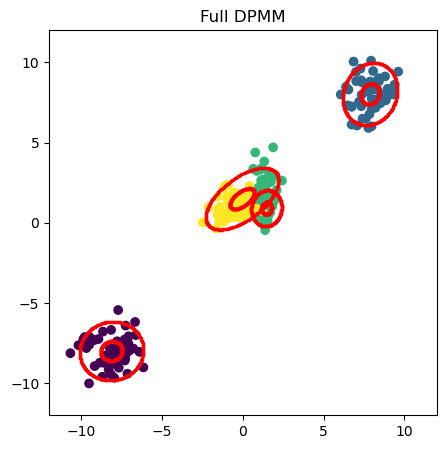

In [7]:
# my_DPMM_full.init_var_params(x)
my_DPMM_full, elbo_full, anim_full, f_full = train_DPMM(my_DPMM_full, 'Full DPMM')
HTML(anim_full.to_html5_video())
f_full # comment this line to see the animation

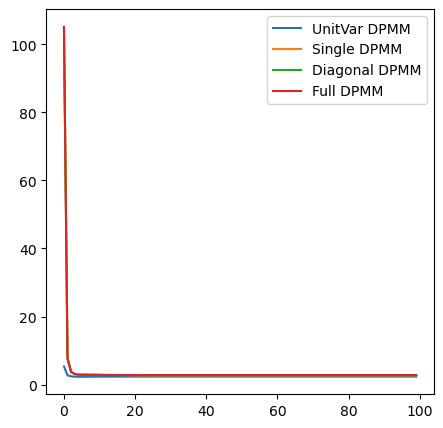

In [8]:
plt.figure(figsize=(5,5))
plt.plot(np.array(elbo_unit), label='UnitVar DPMM')
plt.plot(np.array(elbo_sing), label='Single DPMM')
plt.plot(np.array(elbo_diag), label='Diagonal DPMM')
plt.plot(np.array(elbo_full), label='Full DPMM')
plt.legend()
plt.show();

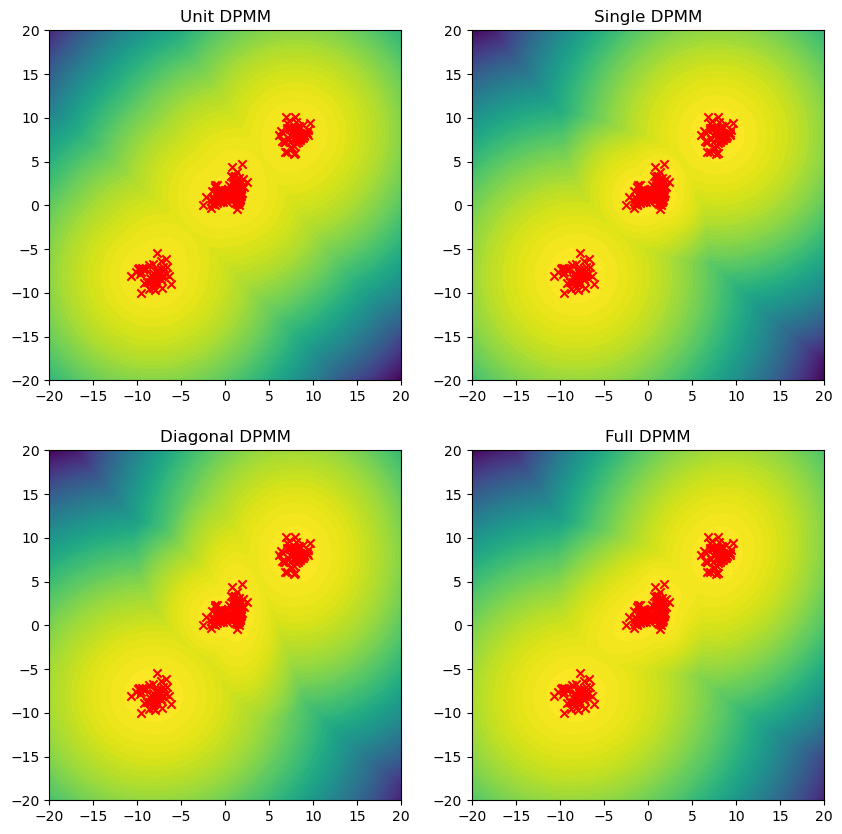

In [9]:
n_rows, n_cols = 2, 2
f, ax_list = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
ax_list = ax_list.reshape(-1)
d_models = {'Unit DPMM': my_DPMM_unit, 'Single DPMM': my_DPMM_sing, 'Diagonal DPMM': my_DPMM_diag, 'Full DPMM': my_DPMM_full}
ppx, ppy = np.meshgrid(np.arange(-20,20,0.1, dtype=np.float32), np.arange(-20,20,0.1, dtype=np.float32))
for i, (k, m) in enumerate(d_models.items()):
    plt.sca(ax_list[i])
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    with th.no_grad():
        _,_,ll = m(th.stack([th.tensor(ppx.reshape(-1)), th.tensor(ppy.reshape(-1))]).T)
    plt.contourf(ppx, ppy, ll.numpy().reshape(*ppx.shape), levels=100)
    plt.scatter(x[:,0], x[:,1], marker='x', c='r')
    plt.title(k)